<a href="https://colab.research.google.com/github/chiaolun/vis-2025-spring/blob/main/2025.02.20%20-%20Elastic%20Collisions%20-%20Newtonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elastic Collision between two particles

In [2]:
import sympy as sp
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [24]:
# -------------------------------
# 1) Define symbolic expressions using Sympy
# -------------------------------

# Define symbolic variables for the positions
x1 = sp.symbols('x1', real=True)
wall_x = sp.symbols('wall_x', real=True)

# Define the repulsive potential energy, which is a constant push away from the wall after you hit it
V = sp.Piecewise((0, x1 > wall_x), (-(x1 - wall_x), x1 <= wall_x))

# Compute forces using Newton's second law: F = -dV/dx
F1 = -sp.diff(V, x1)

# Simplify expressions (they will be computed piecewise internally)
F1 = sp.simplify(F1)

display("F1:", F1)  # Expected to yield: F1 = -sign(x2 - x1) / |x2 - x1|^2

# Lambdify the force expressions for numerical evaluation
f1_func = sp.lambdify((x1, wall_x), F1, modules="numpy")

'F1:'

Piecewise((0, wall_x < x1), (1, True))

<Axes: title={'center': 'Potential Energy vs Separation r'}, xlabel='x', ylabel='Potential Energy V'>

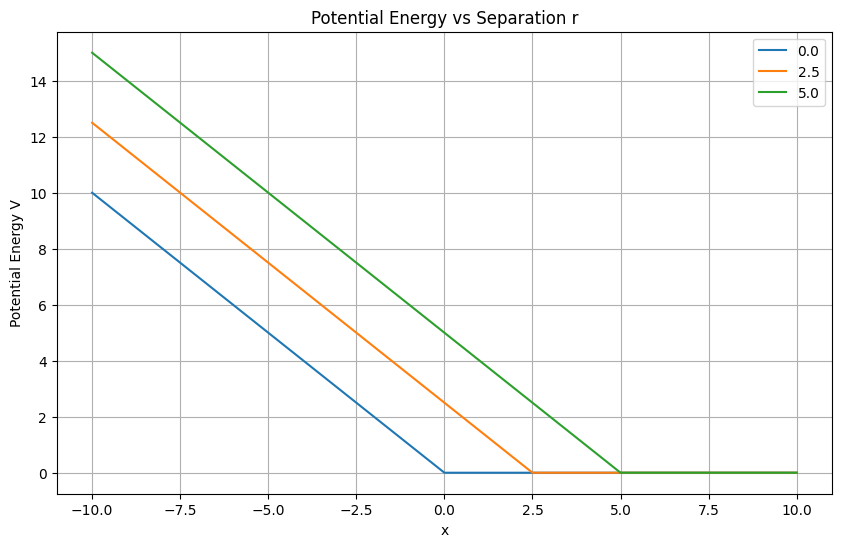

In [ ]:
# Plot the potential energy
x_eval = np.linspace(-10, 10, 1000)
# Create potential functions for different wall positions
wall_x_values = [0, 2.5, 5]
V_funcs = {}
for wall_x_value in wall_x_values:
    V_funcs[wall_x_value] = sp.lambdify((x1,), V.subs(wall_x, wall_x_value), modules="numpy")(x_eval)

# Create DataFrame with all potentials
df = pd.DataFrame(V_funcs, index=x_eval)

# Plot using pandas
df.plot(
    figsize=(10, 6),
    xlabel='x',
    ylabel='Potential Energy V',
    title='Potential Energy vs Separation r',
    grid=True
)

In [25]:
# -------------------------------
# 2) Define the ODE system using Newton's F = m*a
# -------------------------------

# Define masses
m1 = 1.0

def system_newtonian(t, y, wall_v):
    """
    Compute the time-derivative of the state vector using Newtonian mechanics.

    The state vector is:
       y = [x1, x2, v1, v2]
    where
       dx1/dt = v1,
       dx2/dt = v2,
       dv1/dt = F1/m1,
       dv2/dt = F2/m2.
    The forces F1 and F2 are computed using the sympy-derived functions.
    """
    x1, v1 = y
    wall_x = wall_v * t
    F1 = f1_func(x1, wall_x)
    a1 = F1 / m1
    return [v1, a1]

In [42]:
# -------------------------------
# 3) Set up and solve the ODE system
# -------------------------------

# Initial conditions for positions and velocities
x1_0 = 10.0   # initial position of mass 1
v1_0 = -1.0      # initial velocity of mass 1
wall_v_0 = 0. # Wall velocity
y0 = [x1_0, v1_0]

# Define simulation time span
t_max = 20
t_eval = np.linspace(0, t_max, 1000)

# Solve the system using SciPy's solve_ivp
sol = solve_ivp(system_newtonian, [0, t_max], y0, t_eval=t_eval, rtol=1e-9, atol=1e-9, args=(wall_v_0,))
solution = pd.DataFrame(sol.y.T, columns=['x1', 'v1'], index=sol.t)
solution

,x1,v1
0.00000,10.000000,-1.0
0.02002,9.979980,-1.0
0.04004,9.959960,-1.0
0.06006,9.939940,-1.0
0.08008,9.919920,-1.0
...,...,...
19.91992,7.919920,1.0
19.93994,7.939941,1.0
19.95996,7.959961,1.0
19.97998,7.979981,1.0


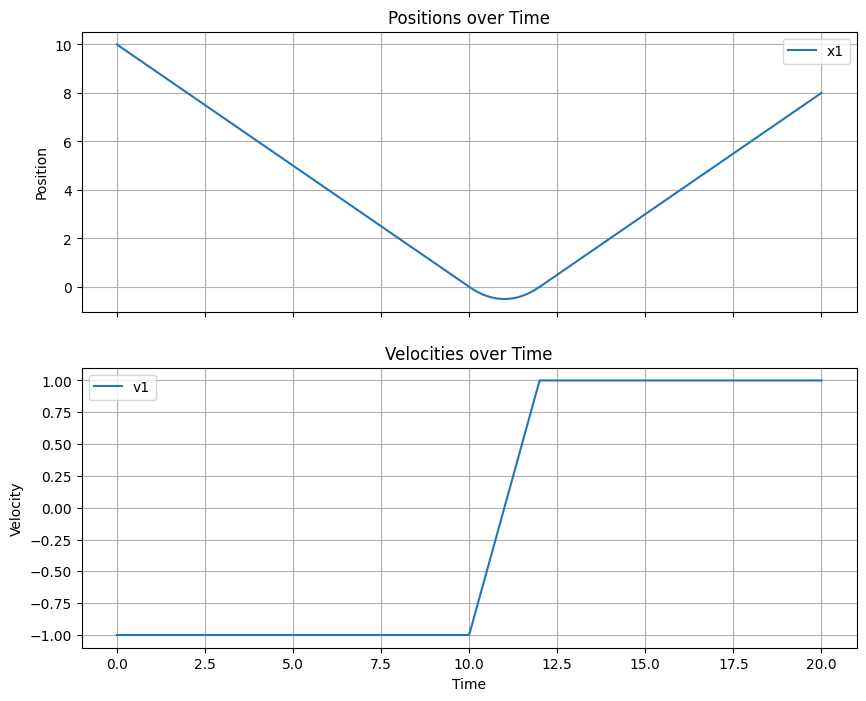

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Plot positions over time
solution[["x1"]].plot(xlabel='Time', ylabel='Position', title='Positions over Time', grid=True, ax=ax1)

# Plot velocities over time
solution[["v1"]].plot(xlabel='Time', ylabel='Velocity', title='Velocities over Time', grid=True, ax=ax2);

In [22]:
thinned_solution = solution.iloc[::10]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, height_ratios=[1, 5])

# Set axis limits for particle animation subplot
x_min = min(thinned_solution[['x1']].min()) - 0.5
x_max = max(thinned_solution[['x1']].max()) + 0.5
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(-1, 1)
ax1.set_title('Particle Collision')

# Create particle objects
particle1, = ax1.plot([], [], 'bo', markersize=5, label='Particle 1')

# Set up position over time subplot
ax2.set_ylim(thinned_solution.index.max(), 0)  # Reversed y-axis limits to make time flow top to bottom
ax2.set_xlim(x_min, x_max)
ax2.set_title('Position vs Time')
ax2.set_ylabel('Time')
ax2.set_xlabel('Position')

# Plot full position data with flipped axes
ax2.plot(thinned_solution['x1'], thinned_solution.index, 'b-', label='Particle 1')
ax2.legend()

# Create time indicator line
time_line, = ax2.plot([], [], 'g-', linewidth=1)

# Animation initialization function
def init():
    particle1.set_data([], [])
    time_line.set_data([], [])
    return particle1, time_line

# Animation update function
def animate(frame):
    # Update particles
    particle1.set_data([thinned_solution.iloc[frame]['x1']], [0])

    # Update time indicator line - now horizontal instead of vertical
    time = thinned_solution.index[frame]
    time_line.set_data([x_min, x_max], [time, time])

    return particle1, time_line

# Create animation
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(thinned_solution),
    interval=50,  # 50ms between frames
    blit=True,
    repeat=False  # Prevent repeating after animation ends
)
plt.close(fig)

# Display animation
HTML(anim.to_html5_video())
